# Milestone 3: Sea Ice Concentration Climatology
> Author: Tien Ly  
> Created: July 2024

## Objective

### Dataset used
Sea Ice Concentration, NOAA/NSIDC Climate Data Record V4, Northern Hemisphere, 25km, Science Quality, 1978-Present, Daily
https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4nh1day.graph


## Import libraries

In [112]:
%pip install pymannkendall

Note: you may need to restart the kernel to use updated packages.


In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import pymannkendall as mk
import datetime
import matplotlib.pyplot as plt
# import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Part 1: Data Preprocessing and Weekly Climatology Calculation

### Get the daily SIC data from ERDDAP

In [4]:
# Open the dataset in xarray
url = 'https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4nh1day'
ds = xr.open_dataset(url)
ds

/Users/tienly/opt/miniconda3/envs/polarwatch/lib/python3.9/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'melt_onset_day_cdr_seaice_conc' has multiple fill values {-1, 255} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


<xarray.Dataset> Size: 72GB
Dimensions:                         (time: 16416, ygrid: 448, xgrid: 304)
Coordinates:
  * time                            (time) datetime64[ns] 131kB 1978-10-25 .....
  * ygrid                           (ygrid) float32 2kB 5.838e+06 ... -5.338e+06
  * xgrid                           (xgrid) float32 1kB -3.838e+06 ... 3.738e+06
Data variables:
    cdr_seaice_conc                 (time, ygrid, xgrid) float32 9GB ...
    melt_onset_day_cdr_seaice_conc  (time, ygrid, xgrid) float32 9GB ...
    nsidc_bt_seaice_conc            (time, ygrid, xgrid) float32 9GB ...
    nsidc_nt_seaice_conc            (time, ygrid, xgrid) float32 9GB ...
    qa_of_cdr_seaice_conc           (time, ygrid, xgrid) float32 9GB ...
    spatial_interpolation_flag      (time, ygrid, xgrid) float32 9GB ...
    stdev_of_cdr_seaice_conc        (time, ygrid, xgrid) float32 9GB ...
    temporal_interpolation_flag     (time, ygrid, xgrid) float32 9GB ...
Attributes: (12/65)
    _NCProperties:                                       version=2,netcdf=4.8...
    acknowledgement:                                     This project was sup...
    cdm_data_type:                                       Grid
    cdr_variable:                                        cdr_seaice_conc
    contributor_name:                                    Walter N. Meier, Flo...
    contributor_role:                                    principal investigat...
    ...                                                  ...
    summary:                                             This data set provid...
    time_coverage_duration:                              P1D
    time_coverage_end:                                   2023-12-31T00:00:00Z
    time_coverage_resolution:                            P1D
    time_coverage_start:                                 1978-10-25T00:00:00Z
    title:                                               Sea Ice Concentratio...

In [5]:
# Extract the SIC data from the dataset
da_sic = ds['cdr_seaice_conc']
da_sic

<xarray.DataArray 'cdr_seaice_conc' (time: 16416, ygrid: 448, xgrid: 304)> Size: 9GB
[2235727872 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 131kB 1978-10-25 1978-10-26 ... 2023-12-31
  * ygrid    (ygrid) float32 2kB 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
  * xgrid    (xgrid) float32 1kB -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
Attributes: (12/13)
    ancillary_variables:  stdev_of_cdr_seaice_conc qa_of_cdr_seaice_conc
    colorBarMaximum:      1.0
    colorBarMinimum:      0.0
    colorBarPalette:      KT_ice
    datum:                +ellps=urn:ogc:def:crs:EPSG::4326
    flag_meanings:        pole_hole lakes coastal land_mask missing_data
    ...                   ...
    ioos_category:        Ice Distribution
    long_name:            NOAA/NSIDC Climate Data Record of Passive Microwave...
    references:           https://nsidc.org/data/g02202/versions/4/
    standard_name:        sea_ice_area_fraction
    units:                1
    valid_range:          [0. 1.]

#### Print out some useful metadata

In [6]:
print('Dimensions:', list(da_sic.dims))
print('Coordinates:', list(da_sic.coords))

Dimensions: ['time', 'ygrid', 'xgrid']
Coordinates: ['time', 'ygrid', 'xgrid']


In [7]:
print('Earliest date:', da_sic.time.values[0])
print('Most recent date:', da_sic.time.values[-1])

Earliest date: 1978-10-25T00:00:00.000000000
Most recent date: 2023-12-31T00:00:00.000000000


In [8]:
print("Is xgrid's first value -->", round(da_sic.xgrid[0].item(), 6))
print('greater than') 
print("xgrid's last value -->", round(da_sic.xgrid[-1].item(), 6))

print(da_sic.xgrid[0].item() > da_sic.xgrid[-1].item())

Is xgrid's first value --> -3837500.0
greater than
xgrid's last value --> 3737500.0
False


In [9]:
print("Is ygrid's first value -->", round(da_sic.ygrid[0].item(), 6))
print('greater than') 
print("ygrid's last value -->", round(da_sic.ygrid[-1].item(), 6))

print(da_sic.ygrid[0].item() > da_sic.ygrid[-1].item())

Is ygrid's first value --> 5837500.0
greater than
ygrid's last value --> -5337500.0
True


###  Compute the weekly means for the 2006-2020 climatological period from daily data

In [11]:
# Extract the dataset for the climatological period: 2006-2020
start_date = '2006-01-01'
end_date = '2020-12-31'
da_sic_bl = da_sic.sel(time=slice(start_date, end_date))
da_sic_bl

<xarray.DataArray 'cdr_seaice_conc' (time: 5391, ygrid: 448, xgrid: 304)> Size: 3GB
[734211072 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 43kB 2006-01-01 2006-01-02 ... 2020-12-31
  * ygrid    (ygrid) float32 2kB 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
  * xgrid    (xgrid) float32 1kB -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
Attributes: (12/13)
    ancillary_variables:  stdev_of_cdr_seaice_conc qa_of_cdr_seaice_conc
    colorBarMaximum:      1.0
    colorBarMinimum:      0.0
    colorBarPalette:      KT_ice
    datum:                +ellps=urn:ogc:def:crs:EPSG::4326
    flag_meanings:        pole_hole lakes coastal land_mask missing_data
    ...                   ...
    ioos_category:        Ice Distribution
    long_name:            NOAA/NSIDC Climate Data Record of Passive Microwave...
    references:           https://nsidc.org/data/g02202/versions/4/
    standard_name:        sea_ice_area_fraction
    units:                1
    valid_range:          [0. 1.]

Since my laptop can't process the entire DataArray at once, I process the data week by week.

In [12]:
# Create a range of weekly periods across 2006-2020
weekly_periods = pd.date_range(start=start_date, end=end_date, freq='W-MON')
# Adjust the start date of the first weekly period to 2006-01-01 instead of 2006-01-02
weekly_periods = pd.DatetimeIndex([weekly_periods[0] - pd.DateOffset(days=1)] + list(weekly_periods[1:]))
weekly_periods

DatetimeIndex(['2006-01-01', '2006-01-09', '2006-01-16', '2006-01-23',
               '2006-01-30', '2006-02-06', '2006-02-13', '2006-02-20',
               '2006-02-27', '2006-03-06',
               ...
               '2020-10-26', '2020-11-02', '2020-11-09', '2020-11-16',
               '2020-11-23', '2020-11-30', '2020-12-07', '2020-12-14',
               '2020-12-21', '2020-12-28'],
              dtype='datetime64[ns]', length=783, freq=None)

**Note:** The sea ice concentration values range from 0 (no ice cover) to 1 (100% ice cover). However, this dataset also includes values above 1 to flag features like lakes, coastline, and land. Therefore, we need to remove those flag values.

In [14]:
weekly_means = []

# Iterate over each weekly period
for i in range(len(weekly_periods)):
    # Define the current week
    week_start = weekly_periods[i]
    if i == len(weekly_periods) - 1: # for the last weekly period
        week_end = pd.to_datetime(datetime.date(2020, 12, 31))
    else:
        week_end = weekly_periods[i + 1] - pd.DateOffset(days=1)
    
    # Extract the current week
    da_sic_weekly = da_sic_bl.sel(time=slice(week_start, week_end))
    
    # Filter out the flag values, keeping only valid SIC values
    da_sic_weekly = da_sic_weekly.where(da_sic_weekly <= 1, drop=True)
    
    # Calculate the weekly mean
    weekly_mean = da_sic_weekly.mean(dim='time')

    weekly_means.append(weekly_mean)

print(len(weekly_means))
print(weekly_means[0])

783
<xarray.DataArray 'cdr_seaice_conc' (ygrid: 448, xgrid: 304)> Size: 545kB
array([[ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.]], dtype=float32)
Coordinates:
  * ygrid    (ygrid) float32 2kB 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
  * xgrid    (xgrid) float32 1kB -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06


In [18]:
# Concatenate the weekly means list into a single DataArray
final_weekly_means = xr.concat(weekly_means, dim='time')
# Assign the time coordinate to the DataArray
final_weekly_means = final_weekly_means.assign_coords(time=weekly_periods)
final_weekly_means

<xarray.DataArray 'cdr_seaice_conc' (time: 783, ygrid: 448, xgrid: 304)> Size: 427MB
array([[[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]]], dtype=float32)
Coordinates:
  * ygrid    (ygrid) float32 2kB 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
  * xgrid    (xgrid) float32 1kB -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
  * time     (time) datetime64[ns] 6kB 2006-01-01 2006-01-09 ... 2020-12-28

### Compute the weekly climatology (2006-2020)

In [19]:
weekly_climatology = final_weekly_means.groupby('time.week').mean(dim='time')
weekly_climatology

/Users/tienly/opt/miniconda3/envs/polarwatch/lib/python3.9/site-packages/xarray/core/accessor_dt.py:441: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(


<xarray.DataArray 'cdr_seaice_conc' (week: 53, ygrid: 448, xgrid: 304)> Size: 29MB
array([[[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]]], dtype=float32)
Coordinates:
  * ygrid    (ygrid) float32 2kB 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
  * xgrid    (xgrid) float32 1kB -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
  * week     (week) int64 424B 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52 53

In [20]:
# Save the DataArrays to a NetCDF file for later sessions
# since the climatology computation is time-consuming
final_weekly_means.to_netcdf('da_weekly_means.nc')
weekly_climatology.to_netcdf('da_clim.nc')

## Part 2: Weekly Sea Ice Concentration Comparison: 2023 vs. Climatology (2006-2020)

This section compares weekly sea ice concentration values for 2023 against the historical climatology (2006-2020).

### Calculate the weekly means for 2023

In [21]:
# Select the 2023 data
da_sic_2023 = da_sic.sel(time=slice('2023-01-01', '2023-12-31'))
# Filter out the flag values
da_sic_2023 = da_sic_2023.where(da_sic_2023 <= 1, drop=True)

In [22]:
# Compute the 2023 weekly means
da_23 = da_sic_2023.groupby('time.week').mean('time')
da_23

/Users/tienly/opt/miniconda3/envs/polarwatch/lib/python3.9/site-packages/xarray/core/accessor_dt.py:441: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(


<xarray.DataArray 'cdr_seaice_conc' (week: 52, ygrid: 448, xgrid: 304)> Size: 28MB
array([[[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]]], dtype=float32)
Coordinates:
  * ygrid    (ygrid) float32 2kB 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
  * xgrid    (xgrid) float32 1kB -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
  * week     (week) int64 416B 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
Attributes: (12/13)
    ancillary_variables:  stdev_of_cdr_seaice_conc qa_of_cdr_seaice_conc
    colorBarMaximum:      1.0
    colorBarMinimum:      0.0
    colorBarPalette:      KT_ice
    datum:                +ellps=urn:ogc:def:crs:EPSG::4326
    flag_meanings:        pole_hole lakes coastal land_mask missing_data
    ...                   ...
    ioos_category:        Ice Distribution
    long_name:            NOAA/NSIDC Climate Data Record of Passive Microwave...
    references:           https://nsidc.org/data/g02202/versions/4/
    standard_name:        sea_ice_area_fraction
    units:                1
    valid_range:          [0. 1.]

### Load the weekly climatology

In [23]:
# Load the weekly climatology from the NetCDF file (in a new session)
da_clim = xr.open_dataarray('da_clim.nc')

**Note:** Since the weekly climatology array has 53 weeks, while the 2023 weekly mean array has 52 weeks, I drop the last week from the climatology array.

In [24]:
print('Number of weeks of the climatology array:', len(da_clim.week))
print('Number of weeks of the 2023 array:', len(da_23.week))

Number of weeks of the climatology array: 53
Number of weeks of the 2023 array: 52


In [25]:
da_clim = da_clim.isel(week=~(da_clim.week == 53))
da_clim

<xarray.DataArray 'cdr_seaice_conc' (week: 52, ygrid: 448, xgrid: 304)> Size: 28MB
[7081984 values with dtype=float32]
Coordinates:
  * ygrid    (ygrid) float32 2kB 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
  * xgrid    (xgrid) float32 1kB -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
  * week     (week) int64 416B 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52

###  Plot the comparison between 2023 weekly means and the climatology

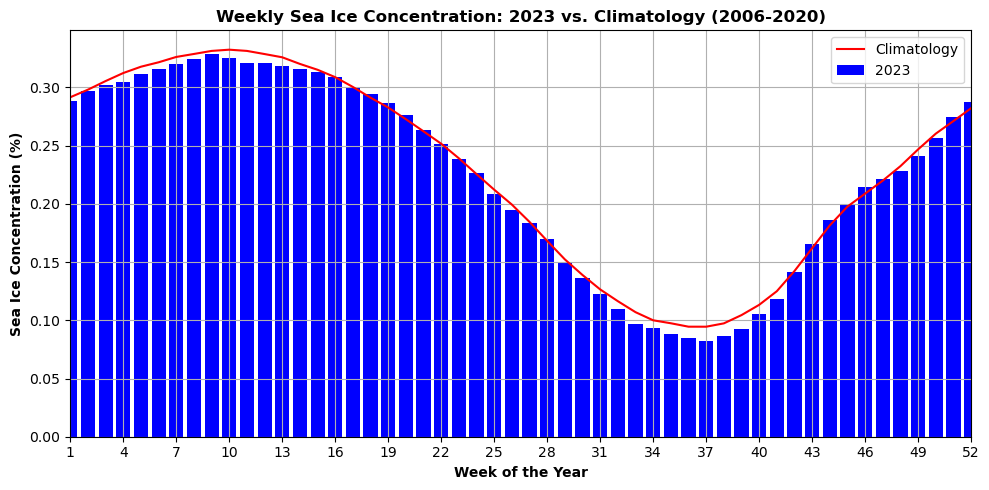

In [26]:
# Compute the spatial means
clim_mean = da_clim.mean(dim=['ygrid', 'xgrid'])
cur_mean = da_23.mean(dim=['ygrid', 'xgrid'])

plt.figure(figsize = [10, 5])
# Plot the climatology
plt.plot(clim_mean.week, clim_mean, label='Climatology', color='r')
# Plot the 2023 weekly means
plt.bar(cur_mean.week, cur_mean, label='2023', color='b')

# Customize the plot
plt.grid()
plt.legend()

plt.xlim([1, 52])
plt.xticks(ticks=clim_mean.week[::3])
plt.ylim(bottom=0)

plt.xlabel('Week of the Year', fontweight='bold')
plt.ylabel('Sea Ice Concentration (%)', fontweight='bold')
plt.title('Weekly Sea Ice Concentration: 2023 vs. Climatology (2006-2020)', fontweight='bold')

plt.tight_layout()

## Part 3: 2023 Sea Ice Concentration: Identifying Anomalies and Trends

### Plot SIC anomalies

In this section, we visualize the anomalies in SIC for 2023 compared to the 2006-2020 climatology. Anomalies are computed as the difference between the 2023 weekly means and the climatological averages.

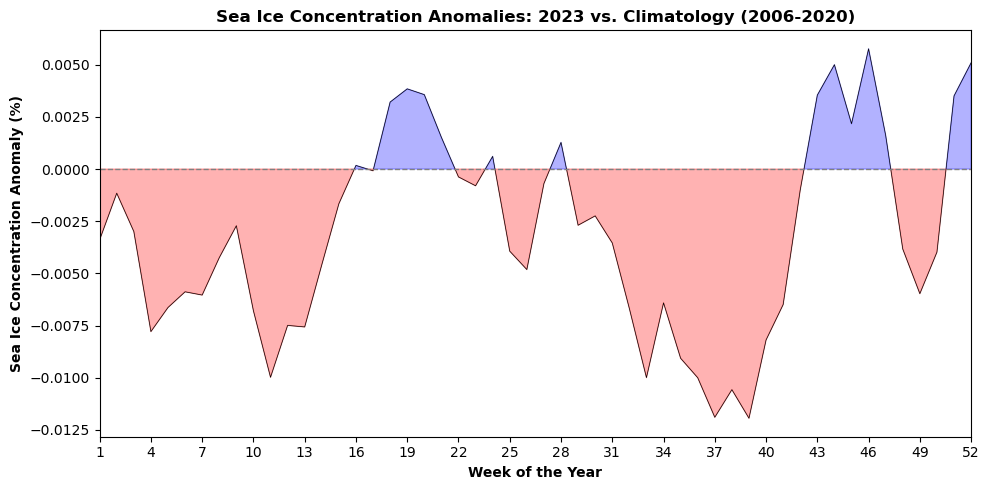

In [27]:
# Calculate anomalies (difference between 2023 weekly means and climatology)
anom_mean = cur_mean - clim_mean

plt.figure(figsize = [10, 5])
# Plot the anomalies over time
plt.plot(anom_mean.week, anom_mean, color='black', linewidth=0.5)
# Fill the area under the curve
plt.fill_between(anom_mean.week, 0, anom_mean, where=(anom_mean >= 0), interpolate=True, color='blue', alpha=0.3)
plt.fill_between(anom_mean.week, 0, anom_mean, where=(anom_mean <= 0), interpolate=True, color='red', alpha=0.3)
# Add a horizontal line at y = 0 for reference (zero anomaly)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)

# Customize the plot
plt.xlim([1, 52])
plt.xticks(ticks=clim_mean.week[::3])

plt.xlabel('Week of the Year', fontweight='bold')
plt.ylabel('Sea Ice Concentration Anomaly (%)', fontweight='bold')
plt.title('Sea Ice Concentration Anomalies: 2023 vs. Climatology (2006-2020)', fontweight='bold')

plt.tight_layout()

### Plot Mann-Kendall test trend data

In this section, we analyze SIC trends for 2023 using the Mann-Kendall test. The Mann-Kendall test assesses whether there is a statistically significant trend (increasing, decreasing, or no trend) over time at each grid cell. This plot helps in understanding spatial patterns of sea ice concentration trends throughout 2023.

In [42]:
# Initialize an empty list to store trend results
trends = []
# Define possible trend outcomes from the Mann-Kendall test
possible_trends = ['decreasing', 'no trend', 'increasing']

# Loop through each grid cell in the ygrid and xgrid dimensions
for i in np.arange(len(da_23.ygrid.values)):
  for j in np.arange(len(da_23.xgrid.values)):
    try:
      # Apply the Mann-Kendall trend test to the time series at each grid cell
      trend = mk.original_test(da_23[:, i, j]).trend
    except:
      # In case of an error, assign a placeholder value
      trend = -9999
    trends.append(trend)

# Reshape the flat trends list into a 2D array matching the ygrid and xgrid dimensions
trends = np.array(trends).reshape(da_23.ygrid.size, da_23.xgrid.size)

# Convert trend outcomes to numerical values
trends[trends == possible_trends[0]] = -1  # 'decreasing' -> -1
trends[trends == possible_trends[1]] = 0   # 'no trend' -> 0
trends[trends == possible_trends[2]] = 1   # 'increasing' -> 1
# Convert the trends array to integer type
trends = trends.astype(int)

# trends now contains the trend results for each grid cell, with:
# -1 indicating a decreasing trend,
#  0 indicating no trend,
#  1 indicating an increasing trend,
# -9999 indicating an error in the trend calculation
trends

array([[    0,     0,     0, ..., -9999, -9999, -9999],
       [    0,     0,     0, ..., -9999, -9999, -9999],
       [    0,     0,     0, ..., -9999, -9999, -9999],
       ...,
       [-9999, -9999, -9999, ...,     0,     0,     0],
       [-9999, -9999, -9999, ...,     0,     0,     0],
       [-9999, -9999, -9999, ...,     0,     0,     0]])

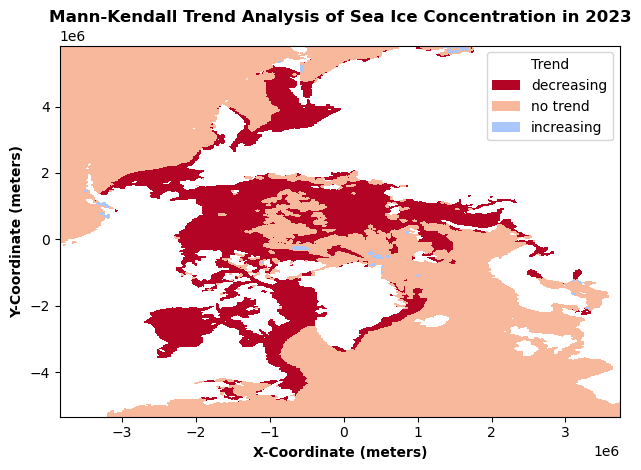

In [100]:
# Create an xarray DataArray from the trends array
mk_trends = xr.DataArray(trends, dims=('ygrid', 'xgrid'),
                         coords={'ygrid': da_23.ygrid, 'xgrid': da_23.xgrid},
                         name='trend')

# Plot the trend data using contourf
cs = mk_trends.where(mk_trends > -9999).plot.contourf(
    cmap='coolwarm_r',
    levels=[-2, -1, 0, 1, 2],  # Define contour levels to align with trend categories
    add_colorbar=False
)

# Customize the plot
artists, labels = cs.legend_elements()
plt.legend(handles=artists, labels=possible_trends, title='Trend')

plt.xlabel('X-Coordinate (meters)', fontweight='bold')
plt.ylabel('Y-Coordinate (meters)', fontweight='bold')
plt.title('Mann-Kendall Trend Analysis of Sea Ice Concentration in 2023', fontweight='bold')

plt.tight_layout()